In [1]:
import pandas as pd
import glob
import numpy as np

## Combining multiple data files (which all must have the same columns)

We can use `glob` to select all files in the data directory. Here the `*` character stands for 'match anything' (and not multiplication, as it is used elsewhere). This line says to get all the files ending in `.csv` that are in any subdirectory of `data/`. 

In [2]:
data_files = glob.glob("data/*/*.csv")
data_files

['data/2020/ucwage-sandiego-2020.csv',
 'data/2020/ucwage-ucop-2020.csv',
 'data/2018/ucwage-ucop-2018.csv',
 'data/2021/ucwage-davis-2021.csv',
 'data/2021/ucwage-losangeles-2021.csv',
 'data/2021/ucwage-sanfrancisco-2021.csv',
 'data/2021/ucwage-berkeley-2021.csv',
 'data/2021/ucwage-sandiego-2021.csv',
 'data/2021/ucwage-ucop-2021.csv',
 'data/2021/ucwage-merced-2021.csv',
 'data/2021/ucwage-santabarbara-2021.csv',
 'data/2021/ucwage-riverside-2021.csv',
 'data/2021/ucwage-irvine-2021.csv',
 'data/2021/ucwage-santacruz-2021.csv',
 'data/2019/ucwage-ucop-2019.csv',
 'data/2017/ucwage-ucop-2017.csv']

## Combining the files together

In [5]:
all_files = []
for file in data_files:
    data_temp = pd.read_csv(file)
    all_files.append(data_temp)

In [6]:
data = pd.concat(all_files)
data

,Year,Location,First\nName,Last\nName,Title,Gross\nPay,Regular\nPay,Overtime\nPay,OtherPay
0,2020,San Diego,,,TEACHER-UNEX-CONTRACT YR,19415.0,0.0,0.0,19415.0
1,2020,San Diego,,,TEACHER-UNEX-CONTRACT YR,51397.0,0.0,0.0,51397.0
2,2020,San Diego,,,RSCH DATA ANL 3,63313.0,63313.0,0.0,0.0
3,2020,San Diego,,,TEACHER-UNEX-CONTRACT YR,3940.0,0.0,0.0,3940.0
4,2020,San Diego,,,CHIEF RESID PHYS-REP,44736.0,41436.0,0.0,3300.0
...,...,...,...,...,...,...,...,...,...
2120,2017,UCOP,JACK,ZHU,ADMIN MGR 2,128967.0,113803.0,0.0,15164.0
2121,2017,UCOP,MANFRED,ZORN,PROJECT POLICY ANL 4,100981.0,100981.0,0.0,0.0
2122,2017,UCOP,ALLEEN,ZULKOWSKI,PARALEGAL 4,92202.0,92202.0,0.0,0.0
2123,2017,UCOP,DAISY,ZUNIGA-GONZALEZ,BLANK AST 3,28538.0,28538.0,0.0,0.0


We also want to rename those columns into things that remove the newlines (or `\n`)

In [7]:
data.columns

Index([' Year', ' Location', ' First\nName', ' Last\nName', ' Title',
       ' Gross\nPay', ' Regular\nPay', ' Overtime\nPay', ' OtherPay'],
      dtype='object')

In [8]:
data.columns = ['year', 'location', 'first_name', 'last_name', 'title', 'total_pay', 'regular_pay', 'overtime_pay', 'other_pay']

data

## Filter to 2021 data

Because 2021 is a number, we don't need to put single quotes around it.

In [10]:
data_2021 = data.query("year == 2021")

## Counting the number of workers in each location:
We will do a `groupby` with the location column. After the groupby function, you should usually specify which column you want to work with. We want to count the number of workers in each location, so it doesn't matter which column you want to work with here. It will matter when we do mean, median, or total salary later, we have to specify which salary column we want to use.

In [162]:
data_2021.groupby('location')['year'].count()

location
Berkeley         16493
Davis            31735
Irvine           19545
Los Angeles      45528
Merced            2457
Riverside         6537
San Diego        20470
San Francisco    31948
Santa Barbara     7454
Santa Cruz        5565
UCOP              2008
Name: year, dtype: int64

We can sort the list smallest to largest:

In [163]:
data_2021.groupby('location')['year'].count().sort_values()

location
UCOP              2008
Merced            2457
Santa Cruz        5565
Riverside         6537
Santa Barbara     7454
Berkeley         16493
Irvine           19545
San Diego        20470
Davis            31735
San Francisco    31948
Los Angeles      45528
Name: year, dtype: int64

We can visualize a horizontal bar graph by adding `.plot(kind='barh')` to the sorted table:

<AxesSubplot:ylabel='location'>

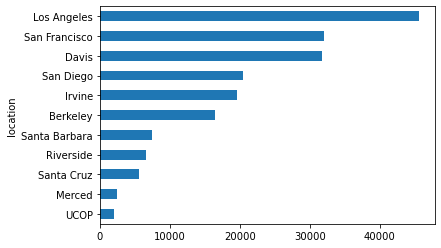

In [164]:
data_2021.groupby('location')['year'].count().sort_values().plot(kind='barh')

# Cleaning data
## Classifying titles
One problem is that there are many different specialized titles, and the payroll system doesn't make it easy to tell them apart. At UCSD we have [this site](http://hr.ucsd.edu/tpp/) which you can use to lookup payroll titles and see a description.

We will create a new function to classify these:

In [165]:
def classify_title(text):
    text = str(text).upper()
    
    if "POSTDOC" in text:
        return "POSTDOC"
    elif "GSHIP" in text or "GSR" in text:
        return "GRAD"
    elif "LECT" in text or "TEACHER" in text:
        return "LECTURER"
    elif "DEAN" in text and "ASST" not in text and "AST" not in text:
        return "EXEC"
    elif "VC" in text and "ASST" not in text and "AST" not in text and 'SVC' not in text:
        return "EXEC"
    elif "CHAN" in text and "ASST" not in text and "AST" not in text:
        return "EXEC"
    elif "CMO MED CTR" in text:
        return "EXEC"
    elif "PROF" in text:
        return "PROF"
    elif "STDT" in text or "MGR" in text or "AST" in text or "SRA" in text or "ADMIN" in text or "SPEC" in text or "HR" in text or "ANL" in text:
        return "ADMIN"
    elif "NURSE" in text or "PHYS" in text or "PAT" in text or "MED C" in text or "CLIN" in text or "PHARM" in text:
        return "MEDICAL-OTHER"
    else:
        return "UNKNOWN"

In [166]:
classify_title("HR GENERALIST 2")

'ADMIN'

In [167]:
classify_title("TEACHG ASST-GSHIP")

'GRAD'

In [168]:
classify_title("ASSOC DEAN")

'EXEC'

In [169]:
classify_title("AST TO DEAN")

'ADMIN'

In [170]:
classify_title("HS ASST CLIN PROF-HCOMP")

'PROF'

### Using `apply` to classify all titles in the dataset

We want to create a new column called `title_class`. This is where we will save the results of applying that function to the `title` column in our original dataset:

In [171]:
data['title_class'] = data['title'].apply(classify_title)
data

,year,location,first_name,last_name,title,total_pay,regular_pay,overtime_pay,other_pay,title_class
0,2020,San Diego,,,TEACHER-UNEX-CONTRACT YR,19415.0,0.0,0.0,19415.0,LECTURER
1,2020,San Diego,,,TEACHER-UNEX-CONTRACT YR,51397.0,0.0,0.0,51397.0,LECTURER
2,2020,San Diego,,,RSCH DATA ANL 3,63313.0,63313.0,0.0,0.0,ADMIN
3,2020,San Diego,,,TEACHER-UNEX-CONTRACT YR,3940.0,0.0,0.0,3940.0,LECTURER
4,2020,San Diego,,,CHIEF RESID PHYS-REP,44736.0,41436.0,0.0,3300.0,MEDICAL-OTHER
5,2020,San Diego,,,TEACHER-UNEX-CONTRACT YR,4948.0,0.0,0.0,4948.0,LECTURER
6,2020,San Diego,,,RECR PRG INSTR 2,1000.0,0.0,0.0,1000.0,UNKNOWN
7,2020,San Diego,,,TEACHER-UNEX-CONTRACT YR,73023.0,0.0,0.0,73023.0,LECTURER
8,2020,San Diego,,,TEACHER-UNEX-CONTRACT YR,62930.0,0.0,0.0,62930.0,LECTURER
9,2020,San Diego,,,TEACHER-UNEX-CONTRACT YR,1613.0,0.0,0.0,1613.0,LECTURER


## Removing those whose total pay for a year is less than $15,000

One big problem is that most people do not join or leave the university on Jan 1st. Most people start in the Fall and end in the Spring, meaning that there are lots of rows from first-year or last-year workers. Because we are interested in what the university is paying workers for a full year, a more robust way to do this is to remove all rows for people making under \\$15,000 a year. Someone working 30 hours a week at \\$15 an hour for a year would be above this and would be included. Someone who recieves $30,000 a year, but is just paid for one or two quarters would not be included.

One problem with this is that it easily filters out the grad students, most of whose salaries for a full year are less than \\$30,000. However, it does not filter out part-year salaries for those who make more than this. The executive who makes \\$600,000 who joins on Dec 1st of a year would have a reported income of \\$50,000 for that year, which would not be filtered out. This likely means that we are slightly underestimating the income of those who make more than \\$30,000 a year. 

Data cleaning is full of political and value choices!


In [136]:
data_cleaned = data.query("total_pay > 15000")

In [137]:
data_2021 = data_cleaned.query("year == 2021")

In [138]:
data_2021['title_class'].value_counts()

ADMIN            59542
UNKNOWN          41199
MEDICAL-OTHER    36915
PROF             20305
GRAD             20211
POSTDOC           6295
LECTURER          5008
EXEC               265
Name: title_class, dtype: int64

We are also going to save a version of the 2021 dataset that is not filtered out, because later we will look at the total money spent on the system:

In [ ]:
data_2021_all = data.query("year == 2021")

## Pivot tables

For a pivot table, you give it a dataset and tell it what a summarized table should look like. You specify the rows (or index), the columns, the values, and how you want to summarize the data. So we want our rows/index to be the title_class, the columns to be the location, and the values to be total_pay. You should also specify the `aggfunc` or aggregation function: should it give you the mean (average), median, sum (total) of all of those values?

In [139]:
pivot_median_total_by_loc = pd.pivot_table(data_2021, index='title_class', columns='location', values='total_pay', aggfunc='median')
pivot_median_total_by_loc

location,Berkeley,Davis,Irvine,Los Angeles,Merced,Riverside,San Diego,San Francisco,Santa Barbara,Santa Cruz,UCOP
title_class,,,,,,,,,,,
ADMIN,73034.0,61795.0,59719.0,61301.0,60404.0,61095.0,60368.0,76692.0,59905.5,65063.0,89780.0
EXEC,337496.5,365934.0,288538.0,379708.0,280272.0,246420.5,353094.0,448962.0,301988.0,276540.0,413989.0
GRAD,27224.0,26823.0,25604.0,26170.0,26309.0,26344.0,26695.0,41527.0,27485.0,26827.0,NaN
LECTURER,42818.0,62905.0,59570.0,41640.0,64107.0,60062.0,56663.0,113406.5,67426.0,49216.0,NaN
MEDICAL-OTHER,71297.0,94545.0,77215.0,78560.0,76496.0,52409.0,82632.5,104222.0,78651.0,64067.0,NaN
POSTDOC,54167.0,54002.0,53873.0,55596.0,48270.0,53731.0,54615.0,57503.0,54470.0,54273.0,NaN
PROF,166702.0,168462.0,177686.0,235157.0,132004.0,134941.5,194381.0,212415.5,162483.0,143997.0,108282.5
UNKNOWN,78843.0,66903.0,63034.0,70806.5,64277.0,66226.5,68422.0,82465.0,65588.5,61973.0,102594.0


<AxesSubplot:xlabel='Median total pay in 2021', ylabel='title_class'>

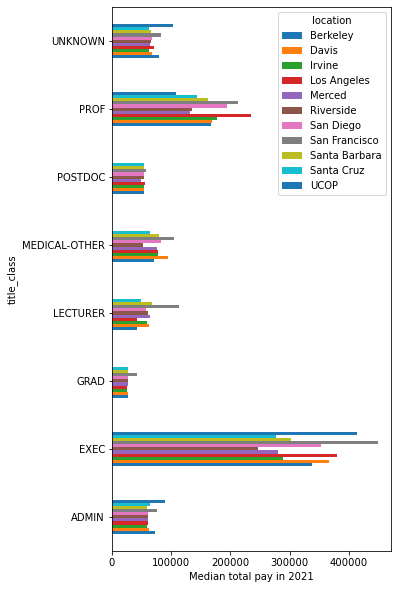

In [146]:
pivot_median_total_by_loc.plot(kind='barh', figsize=(5,10), xlabel="Median total pay in 2021")

We can also change the `aggfunc` to `sum` to add up all the entries in each of our pivot table's rows and columns, instead of finding the median. But first, remember how we removed everyone making less than $15k? We want to put them back, which is why we didn't overwrite the `data` variable with our original dataset:

In [147]:
data_2021_all = data.query("year == 2021")
data_2021_all

,year,location,first_name,last_name,title,total_pay,regular_pay,overtime_pay,other_pay,title_class
0,2021,Davis,*****,*****,POSTDOC-EMPLOYEE,76125.0,76125.0,0.0,0.0,POSTDOC
1,2021,Davis,*****,*****,GSR-FULL FEE REM,19440.0,19440.0,0.0,0.0,GRAD
2,2021,Davis,*****,*****,STDT 4,1110.0,1110.0,0.0,0.0,ADMIN
3,2021,Davis,*****,*****,GSR-FULL FEE REM,7539.0,7539.0,0.0,0.0,GRAD
4,2021,Davis,*****,*****,GSR-FULL FEE REM,33365.0,33365.0,0.0,0.0,GRAD
...,...,...,...,...,...,...,...,...,...,...
11349,2021,Santa Cruz,AMY,ZUROEVESTE,BLANK AST 3,50745.0,50445.0,0.0,300.0,ADMIN
11350,2021,Santa Cruz,THOMAS,ZUUR,AUTO EQUIP OPR SR,39810.0,38134.0,458.0,1217.0,UNKNOWN
11351,2021,Santa Cruz,ANN,ZWEIG,BIOINFORMATICS MGR 1,135039.0,134439.0,0.0,600.0,ADMIN
11352,2021,Santa Cruz,JUAN,ZWOLINSKI,ASSOC RES-FY-NON REP,113925.0,113925.0,0.0,0.0,UNKNOWN


In [148]:
pivot_sum_total_by_loc = pd.pivot_table(data_2021_all, index='title_class', columns='location', values='total_pay', aggfunc='sum')
pivot_sum_total_by_loc

location,Berkeley,Davis,Irvine,Los Angeles,Merced,Riverside,San Diego,San Francisco,Santa Barbara,Santa Cruz,UCOP
title_class,,,,,,,,,,,
ADMIN,457838327.0,701672470.0,430521290.0,1.224781e+09,58758648.0,139671202.0,450976091.0,9.008878e+08,157399552.0,147219226.0,138952758.0
EXEC,13049267.0,9474667.0,15300664.0,1.480546e+07,4775046.0,8845040.0,5183925.0,7.938951e+06,5941120.0,5114683.0,413989.0
GRAD,121129574.0,95697283.0,70064368.0,1.032665e+08,17682677.0,48497121.0,97016895.0,1.155581e+07,61698281.0,40234765.0,NaN
LECTURER,65865583.0,43305264.0,42716081.0,7.450215e+07,14525257.0,21005424.0,30270253.0,1.673938e+06,31267722.0,22885055.0,NaN
MEDICAL-OTHER,12448127.0,809009677.0,395759093.0,1.020375e+09,949569.0,12058948.0,432230911.0,1.213417e+09,3454913.0,2649070.0,NaN
POSTDOC,58494659.0,42526850.0,22406002.0,5.004998e+07,3485346.0,12607870.0,37007098.0,6.636724e+07,17887511.0,8616062.0,NaN
PROF,328215895.0,604555312.0,497524355.0,1.190971e+09,45254380.0,144308666.0,459464009.0,9.823776e+08,173943284.0,100882254.0,10610452.0
UNKNOWN,350548112.0,570281608.0,300553565.0,7.823244e+08,33255854.0,95396224.0,301380627.0,6.127510e+08,120650332.0,89437273.0,81343831.0


<AxesSubplot:ylabel='title_class'>

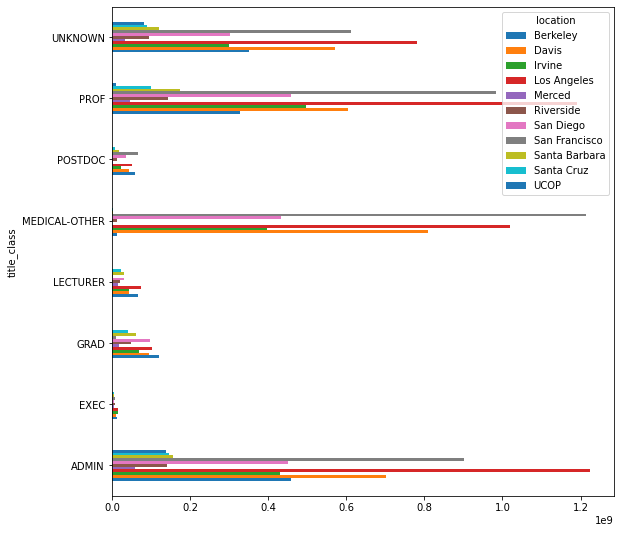

In [149]:
pivot_sum_total_by_loc.plot(kind='barh', figsize=(9,9))

We can stack the bar graph to make this easier to visualize the total UC spending for each category:

<AxesSubplot:xlabel='Billions of dollars spent in 2021', ylabel='title_class'>

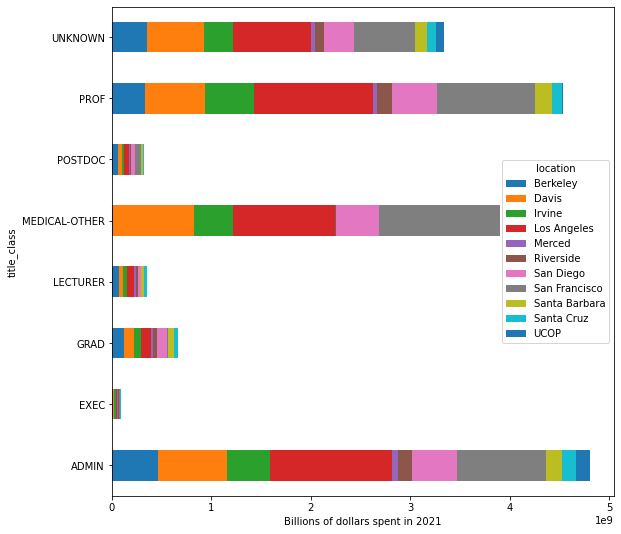

In [151]:
pivot_sum_total_by_loc.plot(kind='barh', figsize=(9,9), stacked=True, xlabel="Billions of dollars spent in 2021")

Instead of a pivot table, a `groupby` works if you just want to aggregate across one category:

In [154]:
data_2021_all.groupby('title_class')['total_pay'].sum()

title_class
ADMIN            4.808678e+09
EXEC             9.084281e+07
GRAD             6.668433e+08
LECTURER         3.480167e+08
MEDICAL-OTHER    3.902353e+09
POSTDOC          3.194486e+08
PROF             4.538107e+09
UNKNOWN          3.337923e+09
Name: total_pay, dtype: float64

<AxesSubplot:ylabel='title_class'>

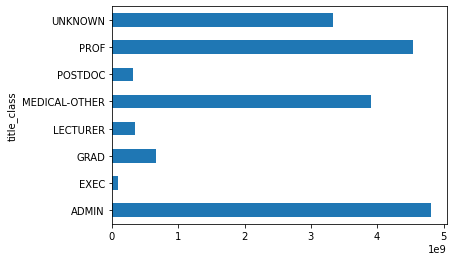

In [155]:
data_2021_all.groupby('title_class')['total_pay'].sum().plot(kind='barh')

In [159]:
pd.set_option('display.min_rows', 30)
pd.set_option('display.max_rows', 100)

In [161]:
data_2021_all.query("title_class == 'EXEC'").sort_values('total_pay', ascending=False)

,year,location,first_name,last_name,title,total_pay,regular_pay,overtime_pay,other_pay,title_class
16491,2021,San Francisco,TALMADGE E.,KING JR,VC AND DEAN SOM,1089848.0,714226.0,0.0,375622.0,EXEC
43167,2021,Los Angeles,JOHN,MAZZIOTTA,VC AND DEAN SOM,1043862.0,703862.0,0.0,340000.0,EXEC
26220,2021,Irvine,MICHAEL,STAMOS,DEAN,1007930.0,633257.0,0.0,374673.0,EXEC
15418,2021,Irvine,STEVEN,GOLDSTEIN,VC AND DEAN SOM,932156.0,782156.0,0.0,150000.0,EXEC
17199,2021,Davis,ALLISON,BRASHEAR,DEAN,918040.0,627693.0,0.0,290347.0,EXEC
4003,2021,San Francisco,MICHAEL,BLUM,ASSOC VICE CHANC,894026.0,331387.0,0.0,562639.0,EXEC
17570,2021,San Diego,DAVID,BRENNER,VC AND DEAN SOM,861244.0,641244.0,0.0,220000.0,EXEC
7702,2021,Riverside,DEBORAH,DEAS,VC AND DEAN SOM,856333.0,706333.0,0.0,150000.0,EXEC
13393,2021,San Francisco,SAM,HAWGOOD,CHAN,838524.0,829608.0,0.0,8916.0,EXEC
28597,2021,Davis,JAMES,KIRK,CMO MED CTR,781624.0,633297.0,0.0,148327.0,EXEC
